In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express  as px
import datetime
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()
API_KEY = os.getenv("API_KEY")
print("API Key:", API_KEY)

API Key: 51587799c13f9ee1738ae56e98a76a93b4fd343c472f0d96f40254cbf5833337


In [3]:
import cryptocompare
cryptocompare.cryptocompare._set_api_key_parameter("API_KEY")

'&api_key=API_KEY'

In [4]:
df = pd.DataFrame(cryptocompare.get_historical_price_day('BTC', 'USD', limit=2000, exchange='CCCAGG', toTs=datetime.datetime(2023,6,1)))  #YYYY,MM,DD       2017 to 2023 MAY
df.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,1512691200,17294.85,13906.10,16867.98,286762.02,4.546015e+09,16047.61,direct,
1,1512777600,16313.18,13151.47,16048.18,181979.81,2.699876e+09,14843.42,direct,
2,1512864000,15783.20,13031.00,14839.98,201620.09,2.904038e+09,15059.60,direct,
3,1512950400,17399.18,15024.56,15060.45,159724.56,2.634268e+09,16732.47,direct,
4,1513036800,17560.65,16254.53,16733.29,132846.57,2.246139e+09,17083.90,direct,


In [5]:
df.drop(['conversionSymbol', "conversionType", "volumefrom",'volumeto'],axis=1, inplace=True)
df

,time,high,low,open,close
0,1512691200,17294.85,13906.10,16867.98,16047.61
1,1512777600,16313.18,13151.47,16048.18,14843.42
2,1512864000,15783.20,13031.00,14839.98,15059.60
3,1512950400,17399.18,15024.56,15060.45,16732.47
4,1513036800,17560.65,16254.53,16733.29,17083.90
...,...,...,...,...,...
1996,1685145600,26899.17,26585.27,26721.25,26872.08
1997,1685232000,28253.91,26790.38,26872.08,28077.15
1998,1685318400,28456.94,27548.48,28077.15,27746.07
1999,1685404800,28049.83,27567.55,27746.07,27702.14


## training data is from 12 Dec 2017  to  31 MAY 2023

In [6]:
df["Date"]= df.apply(lambda df: datetime.datetime.fromtimestamp(df["time"] ).date(),axis=1)
df

,time,high,low,open,close,Date
0,1512691200,17294.85,13906.10,16867.98,16047.61,2017-12-08
1,1512777600,16313.18,13151.47,16048.18,14843.42,2017-12-09
2,1512864000,15783.20,13031.00,14839.98,15059.60,2017-12-10
3,1512950400,17399.18,15024.56,15060.45,16732.47,2017-12-11
4,1513036800,17560.65,16254.53,16733.29,17083.90,2017-12-12
...,...,...,...,...,...,...
1996,1685145600,26899.17,26585.27,26721.25,26872.08,2023-05-27
1997,1685232000,28253.91,26790.38,26872.08,28077.15,2023-05-28
1998,1685318400,28456.94,27548.48,28077.15,27746.07,2023-05-29
1999,1685404800,28049.83,27567.55,27746.07,27702.14,2023-05-30


In [7]:
fig = px.line(df,x='Date', y=['open','close'])
fig.show()

In [8]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig.show()

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
print(df['close'].head(5))
print(df['close'].values.reshape(-1,1)[:5])

0    16047.61
1    14843.42
2    15059.60
3    16732.47
4    17083.90
Name: close, dtype: float64
[[16047.61]
 [14843.42]
 [15059.6 ]
 [16732.47]
 [17083.9 ]]


In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data  = scaler.fit_transform(df['close'].values.reshape(-1,1))

In [12]:
prediction_days = 60
X_train , y_train = [] , []

#### X_train --> y_train
- 1 - 60 -----> 61th
- 2 - 61 -----> 62nd
- 3 - 62 -----> 63rd


In [13]:
for i in range (prediction_days,len(scaled_data)):
    X_train.append(scaled_data[i-prediction_days:i,0])
    y_train.append(scaled_data[i,0])

#### Now X_train & y-train is in the form of array 
#### Converting them in the form of np.array(to feed in LSTM NN)
- just print and watch X_train and X_train.nparray

In [14]:
X_train , y_train  = np.array(X_train) , np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

##creating LSTM NN

In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout #to prevent overfitting add dropout layer
from keras.layers import Dense
import keras

In [16]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))  #return_seq in True because it will feedback the model as it is Recurrent network
model.add(Dropout(0.2))
model.add(keras.layers.LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(keras.layers.LSTM(100))
model.add(Dropout(0.2))
model.add(keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 32, epochs=10)

Epoch 1/10
61/61 [==============================] - 26s 176ms/step - loss: 0.0126
Epoch 2/10
61/61 [==============================] - 10s 164ms/step - loss: 0.0028
Epoch 3/10
61/61 [==============================] - 10s 162ms/step - loss: 0.0024
Epoch 4/10
61/61 [==============================] - 10s 160ms/step - loss: 0.0024
Epoch 5/10
61/61 [==============================] - 10s 158ms/step - loss: 0.0018
Epoch 6/10
61/61 [==============================] - 10s 161ms/step - loss: 0.0020
Epoch 7/10
61/61 [==============================] - 9s 147ms/step - loss: 0.0018
Epoch 8/10
61/61 [==============================] - 9s 143ms/step - loss: 0.0020
Epoch 9/10
61/61 [==============================] - 9s 141ms/step - loss: 0.0016
Epoch 10/10
61/61 [==============================] - 9s 141ms/step - loss: 0.0020


In [18]:
import pickle
with open('mode_pkl','wb') as files:
    pickle.dump(model,files)

#<--- To use the pickle model ----->
# with open('model_pkl' , 'rb') as f:
#     lr = pickle.load(f)

# check prediction
#lr.predict([[5000]])


### To see the loss weather it is increasing or decresing


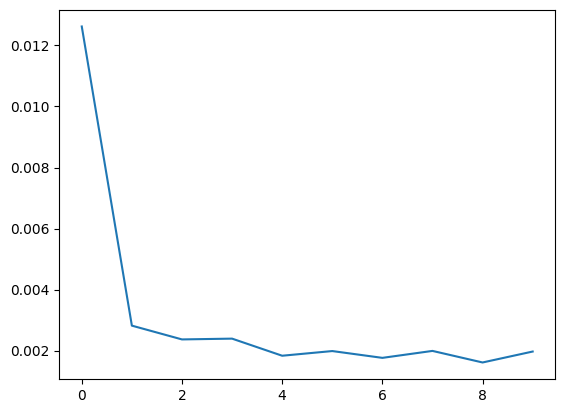

In [19]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

### Testing the Model
### test data ----> price of JUNE MONTH

In [20]:
df_test = pd.read_csv(r"BTC-USD.csv")
df_test.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,01-06-2023,27218.41211,27346.10547,26671.72070,26819.97266,26819.97266,1.467897e+10
1,02-06-2023,26824.55664,27303.86133,26574.64453,27249.58984,27249.58984,1.483742e+10
2,03-06-2023,27252.32422,27317.05273,26958.00391,27075.12891,27075.12891,8.385597e+09
3,04-06-2023,27075.12305,27407.01953,26968.22461,27119.06641,27119.06641,9.360912e+09
4,05-06-2023,27123.10938,27129.98242,25445.16797,25760.09766,25760.09766,2.151329e+10


In [21]:
df_test.drop(labels=['Adj Close','Volume'],inplace=True,axis=1)
df_test = df_test.head(30)

In [22]:
df_test.head()

,Date,Open,High,Low,Close
0,01-06-2023,27218.41211,27346.10547,26671.72070,26819.97266
1,02-06-2023,26824.55664,27303.86133,26574.64453,27249.58984
2,03-06-2023,27252.32422,27317.05273,26958.00391,27075.12891
3,04-06-2023,27075.12305,27407.01953,26968.22461,27119.06641
4,05-06-2023,27123.10938,27129.98242,25445.16797,25760.09766


In [23]:
df_test_close = df_test['Close'].values #it makes df_test_close numpy array

In [24]:
df_test['Close'].head()

0    26819.97266
1    27249.58984
2    27075.12891
3    27119.06641
4    25760.09766
Name: Close, dtype: float64

In [25]:
total_close = pd.concat((df['close'],df_test['Close']))     #axis=0 is default

In [26]:
total_close

0     16047.61000
1     14843.42000
2     15059.60000
3     16732.47000
4     17083.90000
         ...     
25    30271.13086
26    30688.16406
27    30086.24609
28    30445.35156
29    30477.25195
Length: 2031, dtype: float64

In [27]:
model_inputs = total_close[len(total_close)-len(df_test)-prediction_days:].values

C:\Users\nares\AppData\Local\Temp\ipykernel_23916\671961218.py:1: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [28]:
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [29]:
X_test = []

for i in range(prediction_days,len(model_inputs)):
    X_test.append(model_inputs[i-prediction_days:i,0])

In [30]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0] , X_test.shape[1] , 1))

In [31]:
prediction_price = model.predict(X_test)
prediction_price = scaler.inverse_transform(prediction_price)  #prediction price arre in range 0 to 1

1/1 [==============================] - 3s 3s/step


In [32]:
prediction_price_plot = []
for i in range(len(prediction_price)):
    prediction_price_plot.append(prediction_price[i][0])

#### we need to plot total_close and prediction_price_plot on one graph

In [33]:
np.array(df_test['Close'])

array([26819.97266, 27249.58984, 27075.12891, 27119.06641, 25760.09766,
       27238.7832 , 26345.99805, 26508.2168 , 26480.375  , 25851.24023,
       25940.16797, 25902.5    , 25918.72852, 25124.67578, 25576.39453,
       26327.46289, 26510.67578, 26336.21289, 26851.0293 , 28327.48828,
       30027.29688, 29912.28125, 30695.46875, 30548.69531, 30480.26172,
       30271.13086, 30688.16406, 30086.24609, 30445.35156, 30477.25195])

In [34]:
np.array(prediction_price_plot)

array([26953.7  , 27035.365, 27075.014, 27074.54 , 27045.775, 26934.9  ,
       26816.332, 26682.568, 26549.695, 26428.945, 26298.025, 26161.574,
       26027.527, 25906.3  , 25767.48 , 25631.963, 25549.908, 25543.012,
       25596.344, 25713.445, 25947.436, 26365.541, 26928.553, 27599.922,
       28298.379, 28945.158, 29474.932, 29879.836, 30131.541, 30257.383],
      dtype=float32)

In [35]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [36]:
import numpy as np

# Given predicted values from the LSTM model (first array)
predicted_values = np.array([27459.666, 27541.654, 27579.066, 27574.291, 27541.023, 27416.695,
                             27291.047, 27149.502, 27009.955, 26883.514, 26744.27 , 26599.18 ,
                             26457.072, 26329.018, 26181.162, 26038.227, 25953.627, 25948.457,
                             26005.582, 26130.69 , 26385.629, 26849.709, 27476.545, 28226.062,
                             28997.916, 29696.215, 30244.398, 30643.363, 30861.764, 30944.275])

# Given actual values (second array)
actual_values = np.array([26819.97266, 27249.58984, 27075.12891, 27119.06641, 25760.09766,
                          27238.7832 , 26345.99805, 26508.2168 , 26480.375  , 25851.24023,
                          25940.16797, 25902.5    , 25918.72852, 25124.67578, 25576.39453,
                          26327.46289, 26510.67578, 26336.21289, 26851.0293 , 28327.48828,
                          30027.29688, 29912.28125, 30695.46875, 30548.69531, 30480.26172,
                          30271.13086, 30688.16406, 30086.24609, 30445.35156, 30477.25195])

# Calculate Mean Squared Error (MSE)
mse = np.mean((actual_values - predicted_values)**2)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(actual_values - predicted_values))

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate the Coefficient of Determination (R-squared)
def r_squared(actual, predicted):
    y_mean = np.mean(actual)
    ss_total = np.sum((actual - y_mean)**2)
    ss_residual = np.sum((actual - predicted)**2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

accuracy_percentage = r_squared(actual_values, predicted_values) * 100

print("Accuracy (R-squared) in percentage:", accuracy_percentage)


Mean Squared Error (MSE): 1931876.3591797927
Mean Absolute Error (MAE): 1043.6614270000002
Root Mean Squared Error (RMSE): 1389.9195513337427
Accuracy (R-squared) in percentage: 48.36786750988089


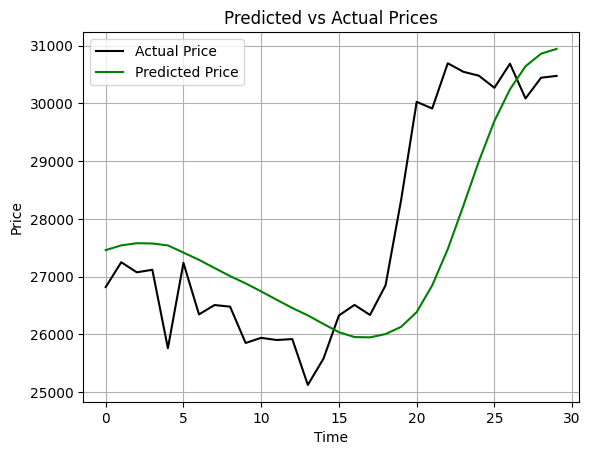

In [37]:
plt.plot(actual_values,color='black',label='Actual Price')
plt.plot(predicted_values,color='green',label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Predicted vs Actual Prices')
plt.legend()
plt.grid(True) 
plt.show()